**Write the names of all group members (max. 5 members)**:
- Zhexin Wu
- Fangyuan Sun
- Zhiang Wu
- Shuhang Li
- Yaxuan Li

When submitting your work, please follow closely the template below.

In [1]:
# %pip install tensorboard lightning optuna optuna-integration

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import lightning as pl
import optuna
import os
import pickle
import time

from torch.utils.data import TensorDataset, DataLoader
from torch.distributions import Normal
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from lightning.pytorch.callbacks import ModelCheckpoint
from lightning.pytorch.loggers import TensorBoardLogger
from optuna.pruners import MedianPruner
from optuna.integration import PyTorchLightningPruningCallback
from scipy.stats import norm
from typing import Tuple, Union

In [3]:
torch.__version__, torch.cuda.is_available()

('2.4.1+cu118', True)

In [4]:
sns.set_theme()

In [5]:
# Configs
BS_PARAMS = {
    "N": 30,
    "S0": 1,
    "K": 1,
    "T": 30 / 365,
    "r": 0,
    "sigma": 0.5,
}
TRAINING_CONFIGS = {
    "num_train_paths": int(1e5),
    "num_val_paths": int(1e4),
    "train_seed": 100,
    "val_seed": 200,
    "num_epochs": 50,
    "batch_size": 2048,
    "opt_cls": AdamW,
    "lr": 5e-3,
    "scheduler_params": {
        "model_cls": ReduceLROnPlateau,
        "params": {
            "mode": "min",
            "factor": 0.5,
            "patience": 5,
            "min_lr": 1e-5,
            "threshold": 1e-3,
        },
    },
}
TUNING_PARAMS = {
    "n_trials": 30,
}

In [6]:
def compute_short_call_profit(S_0: torch.Tensor, S_T: torch.Tensor, K, T, r, sigma, **kwargs):
    """
    Computes p - g(S_T)
    S_0, S_T: (B,)
    """
    norm = Normal(loc=torch.zeros_like(S_0), scale=torch.ones_like(S_0))
    value_at_expir = torch.maximum(S_T - K, torch.zeros_like(S_T))
    t = 0
    d_plus = 1 / (sigma * (T - t) ** 0.5) * (torch.log(S_0 / K) + (r + sigma ** 2 / 2) * (T - t))
    d_minus = d_plus - sigma * (T - t) ** 0.5
    value_at_t = norm.cdf(d_plus) * S_0 - norm.cdf(d_minus) * K * np.exp(-r * (T - t))
    profit = value_at_t - value_at_expir
    
    return profit


class ResBlock(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(hidden_units, hidden_units), nn.ReLU())
    
    def forward(self, x):
        x = self.net(x) + x
        
        return x
        

class MLP(nn.Module):
    def __init__(self, params: dict):
        """
        params: input_units, num_layers, hidden_units 
        """
        super().__init__()
        self.params = params
        self.use_norm = self.params.get("use_norm", False)
        
        layers = [
            nn.Linear(self.params["input_units"], self.params["hidden_units"]),
            nn.ReLU(),
        ]
        
        if self.use_norm:
#             layers.append(nn.LayerNorm(self.params["hidden_units"]))
            layers.append(nn.BatchNorm1d(self.params["hidden_units"]))
            
        for _ in range(self.params["num_layers"] - 2):  # Excluding input and output layers
#             layers += [
#                 nn.Linear(self.params["hidden_units"], self.params["hidden_units"]),
#                 nn.ReLU(),
#             ]
            layers += [
                ResBlock(self.params["hidden_units"]),
            ]
            if self.use_norm:
#                 layers.append(nn.LayerNorm(self.params["hidden_units"]))
                layers.append(nn.BatchNorm1d(self.params["hidden_units"]))
                
        self.out_layer = nn.Linear(self.params["hidden_units"], 1)
        self.net = nn.Sequential(*layers)
    
    def forward(self, x):
        x_out = self.net(x)
        x_out = self.out_layer(x_out)
        
        return x_out

In [7]:
class HedgingLModule(pl.LightningModule):
    def __init__(self, model: nn.Module, params: dict):
        """
        params: opt_cls, lr,
            scheduler_params: dict; keys: model_cls, params: dict 
        """
        super().__init__()
        self.model = model
        self.params = params
    
    def forward(self, x_in):
        x, tt = x_in
        hedging_loss = self.model(x, tt)
        
        return hedging_loss
    
    def predict_step(self, x_in):
        preds = self(x_in)
        return preds
    
    def training_step(self, batch, batch_idx):
        x, tt = batch
        hedging_loss = (self.model(x, tt) ** 2).mean()
        lr = self.trainer.optimizers[0].param_groups[0]["lr"]
        metrics = {"train_hedge_loss": hedging_loss, "lr": lr}
        self.log_dict(metrics, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        
        return hedging_loss
    
    def validation_step(self, batch, batch_idx):
        x, tt = batch
        hedging_loss = (self.model(x, tt) ** 2).mean()
        metrics = {"val_hedge_loss": hedging_loss}
        self.log_dict(metrics, on_step=False, on_epoch=True, prog_bar=True, logger=True)        
    
    def configure_optimizers(self):
        opt = self.params["opt_cls"](self.model.parameters(), lr=self.params["lr"])
        scheduler_params = self.params["scheduler_params"]
        scheduler = scheduler_params["model_cls"](opt, **scheduler_params["params"])
        
        opt_config = {
            "optimizer": opt,
            "lr_scheduler": {
                "scheduler": scheduler,
                "monitor": "val_hedge_loss",
                "interval": "epoch",
            }
        }
        
        return opt_config

    
def predict(trainer: pl.Trainer, pl_model: pl.LightningModule, data_module: pl.LightningDataModule):
    preds = trainer.predict(pl_model, data_module)
    preds = torch.cat(preds).cpu().numpy()
    
    return preds

In [8]:
def dict2str(params: dict):
    out_str = "__".join([f"{key}_{val if isinstance(val, int) else round(val, 3)}".replace(".", "_") for key, val in params.items()])
    
    return out_str


def train_main(
    model_cls,
    data_module_main,
    model_params: dict,
    training_config: dict,
    ckpt_root_dir: str = "ckpts/",
    log_root_dir: str = "logs",
):  
    def objective(trial: optuna.trial.Trial):
        tunable_params = {
            "num_layers": trial.suggest_int("num_layers", 3, 10),
            "hidden_units": trial.suggest_int("hidden_units", 32, 256, log=True),
        }
        model_params.update(tunable_params)
        model = model_cls(model_params)
        pl_model = HedgingLModule(model, training_config)
        local_path = dict2str(tunable_params)
        model_ckpt = ModelCheckpoint(
            dirpath=os.path.join(ckpt_root_dir, model_cls.__name__, local_path),  # e.g: ckpts/Autonomou/{hyper_params}
            filename="{epoch}_{val_hedge_loss:.3e}",
            monitor="val_hedge_loss",
            mode="min",
            save_top_k=1,
        )
        logger = TensorBoardLogger(
            save_dir=log_root_dir,
            name=model_cls.__name__,
            version=local_path,
        )
        trainer = pl.Trainer(
            max_epochs=training_config["num_epochs"],
            callbacks=[model_ckpt, PyTorchLightningPruningCallback(trial, monitor="val_hedge_loss")],
            logger=logger,
        )
        trainer.logger.log_hyperparams(tunable_params)
        trainer.fit(pl_model, data_module_main)
        
        preds = predict(trainer, pl_model, data_module_main)
        mse = (preds ** 2).mean().item()
#         std = preds.std().item()
        
        return mse
    
    return objective

# Exercise 1

### Question 1.a

Check that $ S_t = s_0 \exp \left( \sigma W_t - \frac{1}{2} \sigma^2 t \right)$ solves the Black-Scholes SDE.

<span style="color: blue;"><b>Solution:</b></span>

Let 
$$f(t, W_t) := s_0 \cdot \exp(\sigma W_t - \frac{1}{2}\sigma^2t)$$
We have:
$$
\begin{align*}
    f_t(t, W_t) &= -\frac{1}{2}\sigma^2 \cdot S_t\\
    f_x(t, W_t) &= \sigma \cdot S_t\\
    f_{xx}(t, W_t) &= \sigma^2 \cdot S_t
\end{align*}
$$
Then
$$\begin{align*}
    dS_t &= df(t, W_t) \\
    &= (f_t(t, W_t) + \frac{1}{2} f_{xx}(t, W_t))dt + f_x(t, W_t)dW_t\\
    &= S_t \cdot \big((-\frac{1}{2}\sigma^2 + \frac{1}{2}\sigma^2)dt + \sigma dW_t\big)\\
    &= \sigma S_t dW_t
\end{align*}$$

Since we assume $r = 0$, we conclude that $S_t = s_0 \exp( \sigma W_t - \frac{1}{2} \sigma^2 t)$ solves the Black-Scholes SDE.

### Question 1.b - Generate dataset

In [9]:
class BSDataModule(pl.LightningDataModule):
    def __init__(self, params: dict):
        """
        params: batch_size, num_train_paths, num_val_paths, bs_params
        """
        super().__init__()
        self.params = params
        self.bs_params = params["bs_params"]
    
    def setup(self, stage: str = "fit"):
        train_seed = self.params.get("train_seed", None)
        val_seed = self.params.get("val_seed", None)
        
        if stage == "fit":
            paths, _, tt_input = self.generate_paths(self.params["num_train_paths"], train_seed)
            self.train_ds = TensorDataset(torch.log(paths), tt_input)
            paths, _, tt_input = self.generate_paths(self.params["num_val_paths"], val_seed)
            self.val_ds = TensorDataset(torch.log(paths), tt_input)
            
        if stage in ["test", "predict"]:
            paths, _, tt_input = self.generate_paths(self.params["num_val_paths"], val_seed)
            self.test_ds = TensorDataset(torch.log(paths), tt_input)
    
    def train_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.train_ds, batch_size=self.params["batch_size"], shuffle=True)
        return data_loader
    
    def val_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.val_ds, batch_size=self.params["batch_size"])
        return data_loader
    
    def test_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.test_ds, batch_size=self.params["batch_size"])
        return data_loader
    
    def predict_dataloader(self) -> DataLoader:
        data_loader = DataLoader(self.test_ds, batch_size=self.params["batch_size"])
        return data_loader
    
    def generate_paths(self, num_paths: int, seed=None) -> Tuple[torch.Tensor]:
        if seed is not None:
            torch.manual_seed(seed)
        tt = torch.linspace(0, self.bs_params["T"], self.bs_params["N"] + 1)  # (N + 1,)
        tt_input = torch.sqrt(self.bs_params["T"] - tt)  # (N + 1,)
        tt_input = torch.tile(tt_input, (num_paths, 1))  # (num_paths, N + 1)
        s0_all = self.bs_params["S0"] * torch.ones(num_paths) # (num_paths,)
        paths = [s0_all]
        tt_step = self.bs_params["T"] / self.bs_params["N"]
        
        for i in range(self.bs_params["N"]):
            last_step = paths[-1]
            Z_iter = torch.randn_like(last_step)
            next_step = last_step * torch.exp(-self.bs_params["sigma"] ** 2 / 2 * tt_step + \
                                              self.bs_params["sigma"] * (tt_step ** 0.5) * Z_iter)
            paths.append(next_step)
        
        paths = torch.stack(paths, dim=1)  # (num_paths, N + 1)
        
        # (num_paths, N + 1), (N + 1,), (num_paths, N + 1)
        return paths, tt, tt_input
    
    @staticmethod
    def plot_paths(paths: torch.Tensor, tt: torch.Tensor, **kwargs):
        """
        paths: (num_paths, N + 1)
        tt: (N + 1)
        """
        figsize = kwargs.get("figsize", (9.6, 4.8))
        paths_df = pd.DataFrame(paths.T, index=tt.tolist())  # (N + 1, num_paths)
        fig, axis = plt.subplots(figsize=figsize)
        axis = paths_df.plot(kind="line", ax=axis, legend=False)
        axis.set_title("Simulated Paths")
        axis.set_xlabel("Time")
        axis.set_ylabel("Stock Price")
        
        return fig, axis

In [10]:
# Traning and test sets are generated within BSDataModule
data_module_params = TRAINING_CONFIGS.copy()
data_module_params["bs_params"] = BS_PARAMS.copy()
data_module = BSDataModule(data_module_params)
data_module.setup("fit")

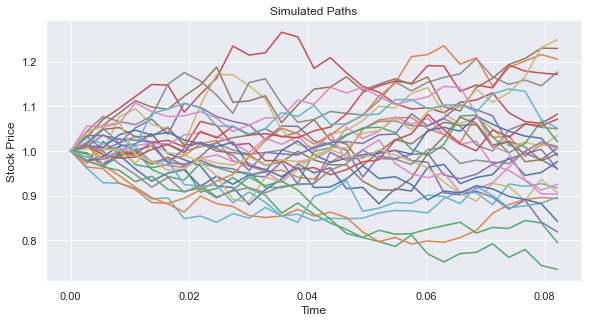

In [11]:
# Generate the training set
paths, tt, _ = data_module.generate_paths(TRAINING_CONFIGS["num_train_paths"])

# Visualize the first 30 paths
_ = BSDataModule.plot_paths(paths[:30, :], tt)

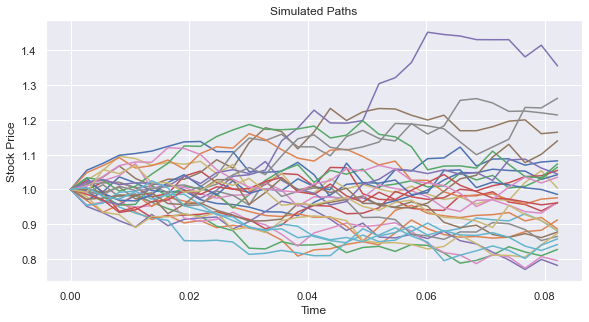

In [12]:
# Generate the test set
paths, tt, _ = data_module.generate_paths(TRAINING_CONFIGS["num_val_paths"])

# Visualize the first 30 paths
_ = BSDataModule.plot_paths(paths[:30, :], tt)

In [13]:
for paths, tt_input in data_module.train_dataloader():
    print(f"{paths.shape}, {tt_input.shape}")
    break

for paths, tt_input in data_module.val_dataloader():
    print(f"{paths.shape}, {tt_input.shape}")
    break

torch.Size([2048, 31]), torch.Size([2048, 31])
torch.Size([2048, 31]), torch.Size([2048, 31])


In [14]:
# This is the LightningDataModule used for training & validation
data_module_main = BSDataModule(data_module_params)
data_module_main.setup("fit")

### Question 1.c - Model implementation

In [15]:
# Implement the deep hedging model

# You may use and edit the code shown in demo.ipynb
class AutonomousModel(nn.Module):
    def __init__(self, params: dict):
        """
        params: num_layers, hidden_units, N, bs_params
        """
        super().__init__()
        self.params = params
        self.bs_params = params["bs_params"]
        mlp_params = dict(input_units=1, num_layers=self.params["num_layers"], hidden_units=self.params["hidden_units"])
        self.models = nn.ModuleList([MLP(mlp_params) for _ in range(self.params["N"])])
    
    def forward(self, x, *args):
        # x: (B, N + 1)
        x = torch.tensor(x)
        profit = 0
        for t in range(len(self.models)):
            stock_price = x[:, t:t + 1]  # (B, 1)
            position = self.models[t](stock_price).flatten()  # (B,)
            profit += position * (torch.exp(x[:, t + 1]) - torch.exp(x[:, t]))  # (B,)
        
        short_call_profit = compute_short_call_profit(torch.exp(x[:, 0]), torch.exp(x[:, -1]), **self.bs_params)  # (B,)
        hedging_loss = -(profit + short_call_profit)        
        
        return hedging_loss

In [16]:
# Sanity check on output shape
model_params = {
    "num_layers": 8,
    "hidden_units": 64,
    "N": BS_PARAMS["N"],
    "bs_params": BS_PARAMS.copy(),
}

data_module_params = TRAINING_CONFIGS.copy()
data_module_params["bs_params"] = BS_PARAMS.copy()
data_module = BSDataModule(data_module_params)
data_module.setup("fit")
for x, tt in data_module.train_dataloader():
    break

model = AutonomousModel(model_params)
hedge_loss = model(x, tt)
hedge_loss.shape

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18668\3262111560.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


torch.Size([2048])

In [17]:
# Debug model
trainer = pl.Trainer(fast_dev_run=100, num_sanity_val_steps=-1)
pl_model = HedgingLModule(model, TRAINING_CONFIGS)
trainer.fit(pl_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 100 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type            | Params | Mode 
--------------------------------------------------
0 | model | AutonomousModel | 754 K  | train
--------------------------------------------------
754 K     Trainable params
0         Non-trainable params
754 K     Total params
3.018     Total estimated model params size (MB)
872       Modules in train mode
0         Modules in eval mode
D:\python\venvs\DeepLearning\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\python\venvs\DeepLearn

Training: |                                                                                                   …

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18668\3262111560.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


### Question 1.d - Model training

In [18]:
# Implement the payoff function of a call option

# Implement a function that returns the Black-Scholes price of a call option with given strike and maturity

# Train the model

In [19]:
# # Uncomment this cell to tune the model. Output is cleared for readability of assignment submission
# model_params = {
#     "num_layers": 8,  # will be replaced
#     "hidden_units": 64,  # will be replaced
#     "N": BS_PARAMS["N"],
#     "bs_params": BS_PARAMS.copy(),
# }
# objective_func = train_main(
#     AutonomousModel, 
#     data_module_main, 
#     model_params, 
#     TRAINING_CONFIGS, 
# )
# pruner = MedianPruner()
# study = optuna.create_study(direction="minimize", pruner=pruner)
# study.optimize(objective_func, **TUNING_PARAMS)

# with open(f"{AutonomousModel.__name__}_study.pkl", "wb") as wf:
#     pickle.dump(study, wf)
    
# study.best_trial.params

In [20]:
with open(f"submissions/{AutonomousModel.__name__}_study.pkl", "rb") as rf:
    study = pickle.load(rf)

study.trials_dataframe().sort_values("value", ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_hidden_units,params_num_layers,state
3,3,0.000081,2024-11-08 17:34:29.768315,2024-11-08 17:37:50.066137,0 days 00:03:20.297822,65,7,COMPLETE
0,0,0.000082,2024-11-08 17:23:51.826933,2024-11-08 17:27:28.078029,0 days 00:03:36.251096,196,7,COMPLETE
2,2,0.000082,2024-11-08 17:30:33.696617,2024-11-08 17:34:29.767330,0 days 00:03:56.070713,50,9,COMPLETE
1,1,0.000082,2024-11-08 17:27:28.079022,2024-11-08 17:30:33.694614,0 days 00:03:05.615592,37,6,COMPLETE
4,4,0.000082,2024-11-08 17:37:50.067137,2024-11-08 17:40:00.732562,0 days 00:02:10.665425,41,3,COMPLETE
28,28,0.000089,2024-11-08 17:42:46.839184,2024-11-08 17:43:19.296861,0 days 00:00:32.457677,48,8,PRUNED
24,24,0.000090,2024-11-08 17:42:04.525260,2024-11-08 17:42:31.815428,0 days 00:00:27.290168,62,6,PRUNED
23,23,0.000094,2024-11-08 17:41:41.775611,2024-11-08 17:42:04.524259,0 days 00:00:22.748648,44,8,PRUNED
5,5,0.000094,2024-11-08 17:40:00.733570,2024-11-08 17:40:17.871075,0 days 00:00:17.137505,57,5,PRUNED
29,29,0.000098,2024-11-08 17:43:19.297866,2024-11-08 17:43:34.488944,0 days 00:00:15.191078,37,6,PRUNED


### Question 1.e - Model evaluation

In [21]:
# Evaluate the hedging losses on the test set

# Plot a histogram of the hedging losses and print mean and standard deviation

In [22]:
model_params = {
    "num_layers": 8,  # will be replaced
    "hidden_units": 64,  # will be replaced
    "N": BS_PARAMS["N"],
    "bs_params": BS_PARAMS.copy(),
}
model_params.update(study.best_params)
model = AutonomousModel(model_params)
pl_model_auto = HedgingLModule.load_from_checkpoint(
    "submissions/ckpts/AutonomousModel/num_layers_7__hidden_units_65/epoch=49_val_hedge_loss=8.132e-05.ckpt",
    model=model,
    params=TRAINING_CONFIGS,
)
trainer = pl.Trainer()
time_start = time.time()
hedge_losses = predict(trainer, pl_model_auto, data_module_main)
time_end = time.time()
auto_eval_runtime = time_end - time_start
hedge_losses.shape, auto_eval_runtime

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\python\venvs\DeepLearning\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18668\3262111560.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x = torch.tensor(x)


((10000,), 2.9562325477600098)

Average square hedge losses: 8.132e-05


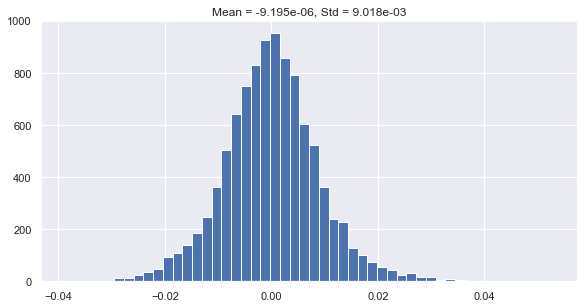

In [23]:
def evaluate_model(hedge_losses: Union[torch.Tensor, np.ndarray]):
    if isinstance(hedge_losses, torch.Tensor):
        hedge_losses = hedge_losses.cpu().numpy()
    hedge_losses_mse = (hedge_losses ** 2).mean()
    fig, axis = plt.subplots(figsize=(9.6, 4.8))
    axis.hist(hedge_losses, bins=50)
    axis.set_title(f"Mean = {hedge_losses.mean():.3e}, Std = {hedge_losses.std():.3e}")
    print(f"Average square hedge losses: {hedge_losses_mse:.3e}")
    
    return fig, axis

_ = evaluate_model(hedge_losses)

A few questions for you to consider...

Have you trained your model well?
- Are the losses centered on zero?
- Is their standard deviation sufficiently small?

How can you improve performance?
- train for more epochs
- try different batch sizes
- try a different learning rate
- use a learning rate scheduler (see https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate)
- try a different activation function
- change the networks' architectures (more/less hidden neurons, more/less hidden layers)
- reduce/increase the learning rate
- implement regularization (use the `weight_decay` argument in the optimizer)
- implement batch-normalization (see https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm1d.html)
- experiment with different optimizers
- ask in the forum

# Exercise 2

### Question 2.a - Compute analytical solution

Show a **step-by-step** derivation of the analytical hedging strategy.

<span style="color: blue;"><b>Solution:</b></span>

$$\begin{align*}
    H^{\text{BS}}_t(s) & = \frac{\partial C(s, t)}{\partial s} \\
    & = \phi(d_+)\frac{\partial d_+}{\partial s}s + \Phi(d_+) - \phi(d_-)\frac{\partial d_-}{\partial s}K\exp(-r(T - t))  \tag{1}
\end{align*}$$

We have
$$\begin{align*}
    \frac{\partial d_+}{\partial s} = \frac{\partial d_-}{\partial s} = \frac{1}{\sigma \sqrt{T - t}}\frac{1}{s}  \tag{2} 
\end{align*}$$

Furthermore,
$$
\begin{align*}
    \phi(d_-) &= \frac{1}{\sqrt{2\pi}}\exp(-\frac{1}{2}\big(d_+ - \sigma\sqrt{T - t})^2\big)\\
    &= \frac{1}{\sqrt{2\pi}}\exp\big(-\frac{1}{2}(d_+^2 - 2d_+\cdot\sigma\sqrt{T - t} + \sigma^2(T - t))\big)\\
    &= \phi(d_+) \cdot \exp\big(d_+\cdot\sigma\sqrt{T - t} - \frac{1}{2}\sigma^2(T - t)\big) \tag{3}
\end{align*}
$$

We have
$$
\begin{align*}
    d_+\cdot\sigma\sqrt{T - t} - \frac{1}{2}\sigma^2(T - t) &= \log\frac{s}{K} + (r + \frac{\sigma^2}{2})(T - t) - \frac{1}{2}\sigma^2(T - t)\\
    &= \log\frac{s}{K} + r(T - t)  \tag{4}
\end{align*}
$$
Plugging (4) into (3), we have
$$
\begin{align*}
    \phi(d_-) = \phi(d_+)\frac{s}{K}\exp\big(r(T - t)\big)  \tag{5}
\end{align*}
$$
From (1), (2) and (5):
$$
\begin{align*}
    H^{\text{BS}}_t(s) &= \phi(d_+)\frac{\partial d_+}{\partial s}s + \Phi(d_+) - \phi(d_-)\frac{\partial d_-}{\partial s}K\exp(-r(T - t))\\
    &= \Phi(d_+) + \phi(d_+)\frac{1}{\sigma\sqrt{T - t}} - \phi(d_-)\frac{1}{\sigma\sqrt{T - t}}\frac{K}{s}\exp\big(-r(T - t)\big)\\
    &= \Phi(d_+) + \phi(d_+)\frac{1}{\sigma\sqrt{T - t}} - \phi(d_+)\frac{s}{K}\exp\big(-r(T - t)\big)\frac{1}{\sigma\sqrt{T - t}}\frac{K}{s}\exp\big(r(T - t)\big)\\
    &= \Phi(d_+)
\end{align*}
$$

### Question 2.b - Analytical solution evaluation

In [24]:
# Implement the formula you found
def HedgingAnalytic(s: Union[np.ndarray, torch.Tensor], tt: Union[np.ndarray, torch.Tensor], K, T, r, sigma, **kwargs):
    """
    s: (num_paths, N + 1)
    tt: (N + 1, )
    """
    if isinstance(s, torch.Tensor):
        s = s.cpu().numpy()
    if isinstance(tt, torch.Tensor):
        tt = tt.cpu().numpy()
        
#     s = s[:, :-1]
#     tt = tt[:-1]
    d_plus = 1 / (sigma * (T - tt) ** 0.5) * (np.log(s / K) + (r + sigma ** 2 / 2) * (T - tt))
    positions = norm.cdf(d_plus)
    
    # (num_paths, N + 1)
    return positions

C:\Users\lenovo\AppData\Local\Temp\ipykernel_18668\1873933014.py:14: RuntimeWarning: divide by zero encountered in divide
  d_plus = 1 / (sigma * (T - tt) ** 0.5) * (np.log(s / K) + (r + sigma ** 2 / 2) * (T - tt))


Average square hedge losses: 8.041e-05


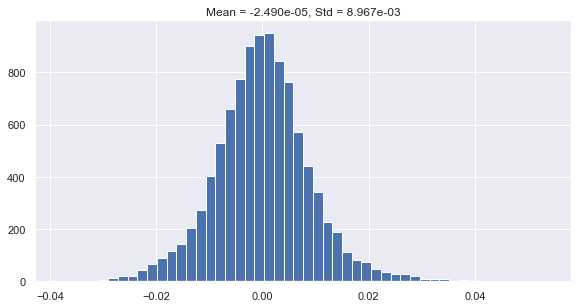

In [25]:
# Evaluate the losses of the analytical hedging strategies on the test set
paths_val, _ = data_module_main.val_ds.tensors
s = torch.exp(paths_val)
tt = torch.linspace(0, BS_PARAMS["T"], BS_PARAMS["N"] + 1)
positions = HedgingAnalytic(s, tt, **BS_PARAMS)
profits = (torch.tensor(positions[:, :-1]) * (s[:, 1:] - s[:, :-1])).sum(dim=1)
short_call_profits = compute_short_call_profit(s[:, 0], s[:, -1], **BS_PARAMS)
hedge_losses = -(profits + short_call_profits)

_ = evaluate_model(hedge_losses)

**Something to think about**: in the Black-Scholes model every option can be perfectly hedged using its analytical hedging strategy.
But the analytical solution you have computed does not give zero losses. Can you explain why?

<span style="color: blue;"><b>Solution:</b></span>

Black-Scholes model assumes continuous time while we are using a discrete time grid.

### Question 2.c - Hedging losses comparison

How does your deep hedging model compare with the analytical solution?
- If it's worse, you must improve its performance (see checklist above)

<span style="color: blue;"><b>Discussion:</b></span>

The deep hedging model is slightly worse than the analytical solution in mean squared hedge loss and std of the hedge losses, but they are comparable. The deep model achieves smaller absolute mean in hedge losses. We describe the hyperparameter tuning process below:
- Instead of using stacks of `nn.Linear`, we add a shortcut in the style of ResNet for each hidden layer.
- Each model is trained for 50 epochs, with batch-size 2048. The batch-size is large enough to support a large starting learning rate 5e-3.
- We used a `ReduceLROnPlateau` scheduler.
- `num_layers` and `hidden_units` are tuned with `optuna` for 30 trials.
- We chose not to use any normalization layers (`BatchNorm1d` or `LayerNorm`), because they result in inferior performance.

### Question 2.d - Learned strategy comparison

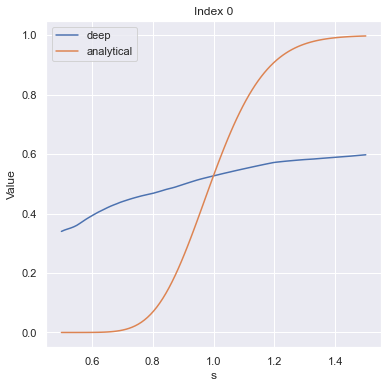

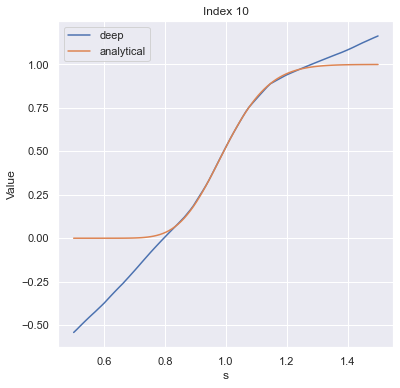

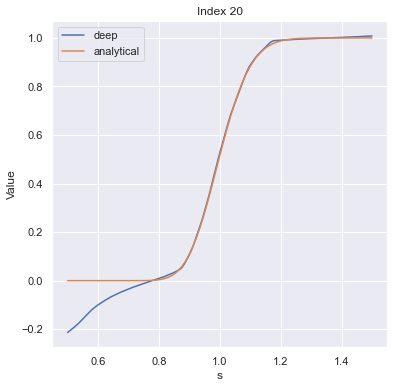

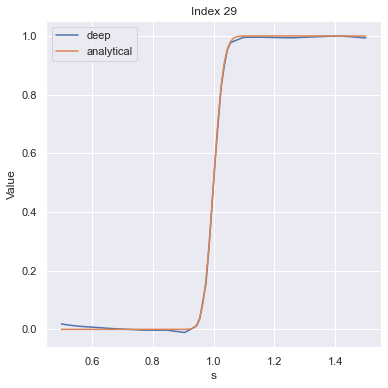

In [26]:
# Plot both the neural network strategies and the analytical hedging strategies
indices = [0, 10, 20, 29]
ss = torch.linspace(0.5, 1.5, 100)[:, None]
tt = torch.linspace(0, BS_PARAMS["T"], BS_PARAMS["N"] + 1)

with torch.no_grad():
    for ind in indices:
        fig, axis = plt.subplots(figsize=(6, 6))
        hedge_deep_iter = pl_model_auto.model.models[ind]
        positions_deep = hedge_deep_iter(torch.log(ss)).flatten()
        positions_ana = HedgingAnalytic(ss, tt[ind:ind + 1], **BS_PARAMS)
        axis.plot(ss, positions_deep, label="deep")
        axis.plot(ss, positions_ana, label="analytical")
        axis.set_title(f"Index {ind}")
        axis.set_xlabel("s")
        axis.set_ylabel("Value")
        axis.legend()

- For what times $t_j$ are the two functions most similar? 
- Why?

<span style="color: blue;"><b>Discussion:</b></span>
    
For later time points (closer to expiration), deep model is more similar to analytical model, since there is less uncertainty when getting closer to expiration, hence easier for NN to learn.

# Exercise 3

### Question 3.a - Model implementation

In [27]:
# Implement the new deep hedging model
class NonAutonomousModel(nn.Module):
    def __init__(self, params: dict):
        """
        params: num_layers, hidden_units, bs_params
        """
        super().__init__()
        self.params = params
        self.bs_params = params["bs_params"]
        mlp_params = dict(input_units=2, num_layers=self.params["num_layers"], hidden_units=self.params["hidden_units"])
        self.model = MLP(mlp_params)
        
    def forward(self, x, tt):
        # x: (B, N + 1), tt: (B, N + 1)
        B, N = x.shape
        N -= 1
        positions = self.model(torch.stack([x[:, :-1], tt[:, :-1]], dim=-1).reshape(-1, 2))  # (B, N, 2) -> (B * N, 2) -> (B * N,)
        positions = positions.reshape(B, N)  # (B, N)
        profits = positions * (torch.exp(x[:, 1:]) - torch.exp(x[:, :-1]))  # (B, N) * (B, N) -> (B, N)
        profit = profits.sum(dim=1)  # (B,)
        
        short_call_profit = compute_short_call_profit(torch.exp(x[:, 0]), torch.exp(x[:, -1]), **self.bs_params)  # (B,)
        hedging_loss = -(profit + short_call_profit)
        
        return hedging_loss

In [28]:
# Sanity check on output shape
model_params = {
    "num_layers": 3,
    "hidden_units": 32,
    "N": BS_PARAMS["N"],  # not used
    "bs_params": BS_PARAMS.copy(),
}

data_module_params = TRAINING_CONFIGS.copy()
data_module_params["bs_params"] = BS_PARAMS.copy()
data_module = BSDataModule(data_module_params)
data_module.setup("fit")
for x, tt in data_module.train_dataloader():
    break

model = NonAutonomousModel(model_params)
hedge_loss = model(x, tt)
hedge_loss.shape

torch.Size([2048])

In [29]:
# Debug model
trainer = pl.Trainer(fast_dev_run=100, num_sanity_val_steps=-1)
pl_model = HedgingLModule(model, TRAINING_CONFIGS)
trainer.fit(pl_model, datamodule=data_module)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Running in `fast_dev_run` mode: will run the requested loop using 100 batch(es). Logging and checkpointing is suppressed.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type               | Params | Mode 
-----------------------------------------------------
0 | model | NonAutonomousModel | 1.2 K  | train
-----------------------------------------------------
1.2 K     Trainable params
0         Non-trainable params
1.2 K     Total params
0.005     Total estimated model params size (MB)
10        Modules in train mode
0         Modules in eval mode
D:\python\venvs\DeepLearning\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.
D:\python\ven

Training: |                                                                                                   …

Validation: |                                                                                                 …

`Trainer.fit` stopped: `max_epochs=1` reached.


### Question 3.b - Model training

In [30]:
# # # Uncomment this cell to tune the model. Output is cleared for readability of assignment submission
# # Train the new deep hedging model
# model_params = {
#     "num_layers": 8,  # will be replaced
#     "hidden_units": 64,  # will be replaced
#     "N": BS_PARAMS["N"],  # not used
#     "bs_params": BS_PARAMS.copy(),
# }
# objective_func = train_main(
#     NonAutonomousModel, 
#     data_module_main, 
#     model_params, 
#     TRAINING_CONFIGS, 
# )
# pruner = MedianPruner()
# study = optuna.create_study(direction="minimize", pruner=pruner)
# study.optimize(objective_func, **TUNING_PARAMS)

# with open(f"{NonAutonomousModel.__name__}_study.pkl", "wb") as wf:
#     pickle.dump(study, wf)

# study.best_trial.params

In [31]:
with open(f"submissions/{NonAutonomousModel.__name__}_study.pkl", "rb") as rf:
    study = pickle.load(rf)

study.trials_dataframe().sort_values("value", ascending=True)

,number,value,datetime_start,datetime_complete,duration,params_hidden_units,params_num_layers,state
7,7,0.000081,2024-11-08 13:40:40.905277,2024-11-08 13:42:28.914794,0 days 00:01:48.009517,71,9,COMPLETE
0,0,0.000081,2024-11-08 13:30:11.290482,2024-11-08 13:31:56.585323,0 days 00:01:45.294841,90,6,COMPLETE
23,23,0.000081,2024-11-08 13:49:52.082346,2024-11-08 13:51:22.338658,0 days 00:01:30.256312,87,4,COMPLETE
11,11,0.000081,2024-11-08 13:43:23.617136,2024-11-08 13:45:09.703821,0 days 00:01:46.086685,131,5,COMPLETE
24,24,0.000081,2024-11-08 13:51:22.339658,2024-11-08 13:52:53.565777,0 days 00:01:31.226119,94,4,COMPLETE
19,19,0.000081,2024-11-08 13:47:53.694509,2024-11-08 13:49:38.567697,0 days 00:01:44.873188,162,4,COMPLETE
2,2,0.000081,2024-11-08 13:33:19.707831,2024-11-08 13:36:31.834619,0 days 00:03:12.126788,223,8,COMPLETE
3,3,0.000081,2024-11-08 13:36:31.835616,2024-11-08 13:38:21.973651,0 days 00:01:50.138035,90,8,COMPLETE
4,4,0.000081,2024-11-08 13:38:21.974651,2024-11-08 13:40:26.771390,0 days 00:02:04.796739,137,7,COMPLETE
17,17,0.000081,2024-11-08 13:46:48.355136,2024-11-08 13:47:50.894514,0 days 00:01:02.539378,48,6,PRUNED


### Question 3.c - Model evaluation

In [32]:
# Evaluate the hedging losses on the test set

# Plot a histogram of the hedging losses and print mean and standard deviation
model_params = {
    "num_layers": 8,  # will be replaced
    "hidden_units": 64,  # will be replaced
    "N": BS_PARAMS["N"],
    "bs_params": BS_PARAMS.copy(),
}
model_params.update(study.best_params)
model = NonAutonomousModel(model_params)
pl_model_non_auto = HedgingLModule.load_from_checkpoint(
    "submissions/ckpts/NonAutonomousModel/num_layers_9__hidden_units_71/epoch=34_val_hedge_loss=8.048e-05.ckpt",
    model=model,
    params=TRAINING_CONFIGS,
)
trainer = pl.Trainer()
time_start = time.time()
hedge_losses = predict(trainer, pl_model_non_auto, data_module_main)
time_end = time.time()
non_auto_eval_runtime = time_end - time_start
hedge_losses.shape, non_auto_eval_runtime

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
D:\python\venvs\DeepLearning\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:424: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.


Predicting: |                                                                                                 …

((10000,), 0.1809985637664795)

Average square hedge losses: 8.048e-05


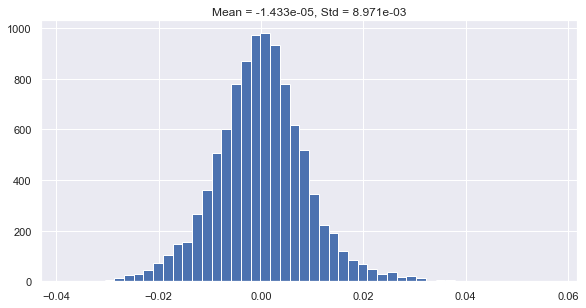

In [33]:
_ = evaluate_model(hedge_losses)

<span style="color: blue;"><b>Discussion:</b></span>

The non-autonomous model and the analytical model have very similar performance. The non-autonomous model achieves smaller absolute mean hedge losses with equivalent standard deviation in hedge losses and mean squared hedge losses.

### Question 3.d - Model comparison

In [34]:
# Compare with the first deep hedging model (Exercise 1)
# Keep the comparison fair: evaluate run-time, performance and number of parameters.

In [35]:
with open(f"submissions/{AutonomousModel.__name__}_study.pkl", "rb") as rf:
    auto_study = pickle.load(rf)
    
with open(f"submissions/{NonAutonomousModel.__name__}_study.pkl", "rb") as rf:
    non_auto_study = pickle.load(rf)

In [36]:
def compare_models(study: optuna.Study, pl_model: HedgingLModule, eval_runtime):
    study_df = study.trials_dataframe().sort_values("value", ascending=True)
    training_time = study_df["duration"][0].total_seconds()
    print(f"Best model configuration: {study.best_params}")
    print(f"Best mean squared hedge loss: {study.best_value:.3e}")
    num_params = sum((p.numel() for p in pl_model.model.parameters()))
    print(f"Number of parameters: {num_params:.2e}")
    print(f"Training time: {training_time:.3f} s")
    print(f"Training time per param: { training_time / num_params:.3e} s")
    print(f"Inference time: {eval_runtime:.3f} s")
    print(f"Inference time per param: {eval_runtime / num_params:.3e} s")

In [37]:
print("Exercise 1: Autonomous model")
print("-" * 100)
compare_models(auto_study, pl_model_auto, auto_eval_runtime)

Exercise 1: Autonomous model
----------------------------------------------------------------------------------------------------
Best model configuration: {'num_layers': 7, 'hidden_units': 65}
Best mean squared hedge loss: 8.132e-05
Number of parameters: 6.49e+05
Training time: 216.251 s
Training time per param: 3.330e-04 s
Inference time: 2.956 s
Inference time per param: 4.552e-06 s


In [38]:
print("Exercise 3: Non-autonomous model")
print("-" * 100)
compare_models(non_auto_study, pl_model_non_auto, non_auto_eval_runtime)

Exercise 3: Non-autonomous model
----------------------------------------------------------------------------------------------------
Best model configuration: {'num_layers': 9, 'hidden_units': 71}
Best mean squared hedge loss: 8.051e-05
Number of parameters: 3.61e+04
Training time: 105.295 s
Training time per param: 2.919e-03 s
Inference time: 0.181 s
Inference time per param: 5.018e-06 s


<span style="color: blue;"><b>Discussion:</b></span>
- Non-autonomous model has superior performance in mean squared hedge loss.
- Non-autonomous model leverages parameter-sharing, so it has fewer parameters and shorter training and inference time.
- However, if we compute "per parameter time", the autonomous model is more time-efficient.
- From the perspective of model generality, non-autonomous model can take any time point input while for autonomous model we can only increase number of sub-models if we want to use a finer time grid, which can be computationally expensive.